In [2]:
# Import necessary libraries
import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout


from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [8]:
# Data
fname='elpv-dataset-1.0/labels.csv'


# Load the dataset
data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
image_fnames = np.char.decode(data['path'])
probs = data['probability']
types = np.char.decode(data['type'])

# Define a function to preprocess the images
def load_and_preprocess_image(fname):
    with Image.open(fname) as image:
        # Preprocess image for ResNet50
        image = image.convert('RGB')
        image = image.resize((224, 224))
        image = np.array(image)
        image = preprocess_input(image)  # Use the imported function here
        return image

# Load and preprocess images
dir = os.path.dirname(fname)
images = np.array([load_and_preprocess_image(os.path.join(dir, fn))
                   for fn in image_fnames])

# Convert probabilities to categorical labels
labels = to_categorical(np.round(probs * 3), num_classes=4)


# One hot encode the types variable

label_encoder = LabelEncoder()
integer_encoded_types = label_encoder.fit_transform(types)

# One-hot encode the integer labels
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_types = integer_encoded_types.reshape(len(integer_encoded_types), 1)
onehot_encoded_types = onehot_encoder.fit_transform(integer_encoded_types)

# Split into training and test
X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(
    images, labels, onehot_encoded_types, test_size=0.25, random_state=42)



# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train 
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
62/62 [==============================] - 119s 2s/step - loss: 0.9014 - accuracy: 0.6575 - val_loss: 0.7516 - val_accuracy: 0.7180
Epoch 2/10
62/62 [==============================] - 112s 2s/step - loss: 0.7123 - accuracy: 0.7332 - val_loss: 0.7561 - val_accuracy: 0.7165
Epoch 3/10
62/62 [==============================] - 111s 2s/step - loss: 0.6479 - accuracy: 0.7464 - val_loss: 0.6831 - val_accuracy: 0.7470
Epoch 4/10
62/62 [==============================] - 111s 2s/step - loss: 0.6215 - accuracy: 0.7612 - val_loss: 0.6750 - val_accuracy: 0.7561
Epoch 5/10
62/62 [==============================] - 110s 2s/step - loss: 0.6025 - accuracy: 0.7754 - val_loss: 0.6612 - val_accuracy: 0.7576
Epoch 6/10
62/62 [==============================] - 110s 2s/step - loss: 0.5752 - accuracy: 0.7835 - val_loss: 0.6609 - val_accuracy: 0.7652
Epoch 7/10
62/62 [==============================] - 111s 2s/step - loss: 0.5549 - accuracy: 0.7947 - val_loss: 0.6470 - val_accuracy: 0.7668
Epoch 8/10
62

21/21 [==============================] - 28s 1s/step
Confusion Matrix for Type mono:
[[142   0   0   5]
 [ 23   0   0   3]
 [ 14   0   0   4]
 [ 22   0   0  60]]

Classification Report for Type mono:
                     precision    recall  f1-score   support

   Fully Functional       0.71      0.97      0.82       147
 Possibly Defective       0.00      0.00      0.00        26
   Likely Defective       0.00      0.00      0.00        18
Certainly Defective       0.83      0.73      0.78        82

           accuracy                           0.74       273
          macro avg       0.38      0.42      0.40       273
       weighted avg       0.63      0.74      0.67       273



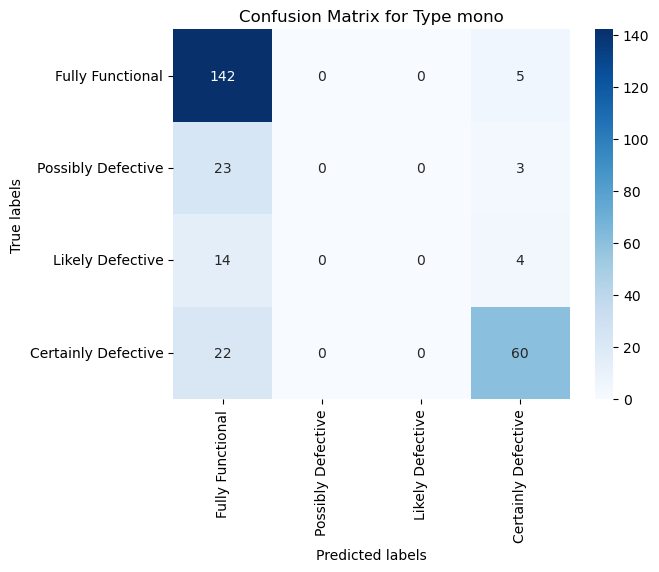

Confusion Matrix for Type poly:
[[219   2   0   4]
 [ 44   2   0   1]
 [ 10   1   0   2]
 [ 32   5   0  61]]

Classification Report for Type poly:
                     precision    recall  f1-score   support

   Fully Functional       0.72      0.97      0.83       225
 Possibly Defective       0.20      0.04      0.07        47
   Likely Defective       0.00      0.00      0.00        13
Certainly Defective       0.90      0.62      0.73        98

           accuracy                           0.74       383
          macro avg       0.45      0.41      0.41       383
       weighted avg       0.68      0.74      0.68       383



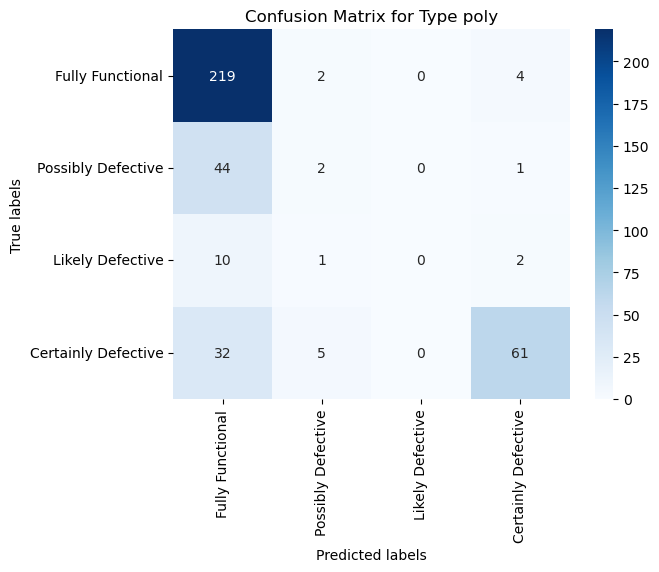

Confusion Matrix for Entire Dataset:
[[361   2   0   9]
 [ 67   2   0   4]
 [ 24   1   0   6]
 [ 54   5   0 121]]

Classification Report for Entire Dataset:
                     precision    recall  f1-score   support

   Fully Functional       0.71      0.97      0.82       372
 Possibly Defective       0.20      0.03      0.05        73
   Likely Defective       0.00      0.00      0.00        31
Certainly Defective       0.86      0.67      0.76       180

           accuracy                           0.74       656
          macro avg       0.44      0.42      0.41       656
       weighted avg       0.66      0.74      0.68       656



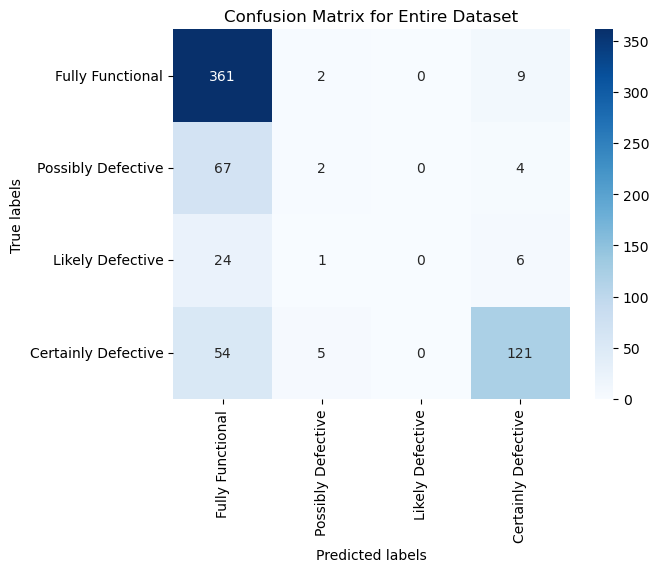

In [19]:
# Predict the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Accuracy stats
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Convert type_test from one-hot encoding to original labels
type_test_labels = label_encoder.inverse_transform(np.argmax(type_test, axis=1))

# Unique types
unique_types = np.unique(type_test_labels)

# Evaluate for each type
for t in unique_types:
    # Indices for current type
    indices = np.where(type_test_labels == t)

    # Subset y_test_classes and y_pred_classes
    y_test_subset = y_test_classes[indices]
    y_pred_subset = y_pred_classes[indices]

    # Confusion Matrix for current type
    cm = confusion_matrix(y_test_subset, y_pred_subset)
    print(f"Confusion Matrix for Type {t}:")
    print(cm)

    # Classification Report for current type
    report = classification_report(y_test_subset, y_pred_subset, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division=0)
    print(f"\nClassification Report for Type {t}:")
    print(report)

    # Visualization of Confusion Matrix for current type
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()
    

cm_total = confusion_matrix(y_test_classes, y_pred_classes)
report_total = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division=0)

print("Confusion Matrix for Entire Dataset:")
print(cm_total)
print("\nClassification Report for Entire Dataset:")
print(report_total)

sns.heatmap(cm_total, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Dataset')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division=0, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop('support', axis=1)

# Plotting
report_df[:-3].plot(kind='bar', figsize=(10, 7))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


# Data Augmentation

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest'
)


train_generator = train_datagen.flow(
    X_train, y_train, 
    batch_size=32  # or your preferred batch size
)

# Load ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers 
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)



# Early stopping to stop training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train 
history = model.fit(train_generator, 
                    epochs=20, 
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, model_checkpoint]
                   )

Epoch 1/20
61/61 [==============================] - 115s 2s/step - loss: 0.8838 - accuracy: 0.6818 - val_loss: 0.7581 - val_accuracy: 0.7180
Epoch 2/20
61/61 [==============================] - 112s 2s/step - loss: 0.7084 - accuracy: 0.7345 - val_loss: 0.6900 - val_accuracy: 0.7332
Epoch 3/20
61/61 [==============================] - 111s 2s/step - loss: 0.6741 - accuracy: 0.7433 - val_loss: 0.6993 - val_accuracy: 0.7393
Epoch 4/20
61/61 [==============================] - 112s 2s/step - loss: 0.6216 - accuracy: 0.7676 - val_loss: 0.6699 - val_accuracy: 0.7409
Epoch 5/20
61/61 [==============================] - 112s 2s/step - loss: 0.6089 - accuracy: 0.7655 - val_loss: 0.6736 - val_accuracy: 0.7515
Epoch 6/20
61/61 [==============================] - 111s 2s/step - loss: 0.5895 - accuracy: 0.7815 - val_loss: 0.6620 - val_accuracy: 0.7424
Epoch 7/20
61/61 [==============================] - 112s 2s/step - loss: 0.5696 - accuracy: 0.7851 - val_loss: 0.6592 - val_accuracy: 0.7515
Epoch 8/20
61